In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

"""
Create Your Own Plasma PIC Simulation (With Python)
Philip Mocz (2020) Princeton Univeristy, @PMocz

Simulate the 1D Two-Stream Instability
Code calculates the motions of electron under the Poisson-Maxwell equation
using the Particle-In-Cell (PIC) method

"""


def getAcc( pos, Nx, boxsize, n0, Gmtx, Lmtx ):
	"""
    Calculate the acceleration on each particle due to electric field
	pos      is an Nx1 matrix of particle positions
	Nx       is the number of mesh cells
	boxsize  is the domain [0,boxsize]
	n0       is the electron number density
	Gmtx     is an Nx x Nx matrix for calculating the gradient on the grid
	Lmtx     is an Nx x Nx matrix for calculating the laplacian on the grid
	a        is an Nx1 matrix of accelerations
	"""
	# Calculate Electron Number Density on the Mesh by 
	# placing particles into the 2 nearest bins (j & j+1, with proper weights)
	# and normalizing
	N          = pos.shape[0]
	dx         = boxsize / Nx
	j          = np.floor(pos/dx).astype(int)
	jp1        = j+1
	weight_j   = ( jp1*dx - pos  )/dx
	weight_jp1 = ( pos    - j*dx )/dx
	jp1        = np.mod(jp1, Nx)   # periodic BC
	n  = np.bincount(j[:,0],   weights=weight_j[:,0],   minlength=Nx);
	n += np.bincount(jp1[:,0], weights=weight_jp1[:,0], minlength=Nx);
	n *= n0 * boxsize / N / dx 
	
	# Solve Poisson's Equation: laplacian(phi) = n-n0
	phi_grid = spsolve(Lmtx, n-n0, permc_spec="MMD_AT_PLUS_A")
	
	# Apply Derivative to get the Electric field
	E_grid = - Gmtx @ phi_grid
	
	# Interpolate grid value onto particle locations
	E = weight_j * E_grid[j] + weight_jp1 * E_grid[jp1]
	
	a = -E

	return a
	


def main():
	""" Plasma PIC simulation """
	
	# Simulation parameters
	N         = 40000   # Number of particles
	Nx        = 400     # Number of mesh cells
	t         = 0       # current time of the simulation
	tEnd      = 200      # time at which simulation ends
	dt        = 1       # timestep
	boxsize   = 50      # periodic domain [0,boxsize]
	n0        = 1       # electron number density
	vb        = 3       # beam velocity
	vth       = 1       # beam width
	A         = 0.1     # perturbation
	plotRealTime = True # switch on for plotting as the simulation goes along
	
	# Generate Initial Conditions
	np.random.seed(42)            # set the random number generator seed
	# construct 2 opposite-moving Guassian beams
	pos  = np.random.rand(N,1) * boxsize  
	vel  = vth * np.random.randn(N,1) + vb
	Nh = int(N/2)
	vel[Nh:] *= -1
	# add perturbation
	vel *= (1 + A*np.sin(2*np.pi*pos/boxsize))
	
	# Construct matrix G to computer Gradient  (1st derivative)
	dx = boxsize/Nx
	e = np.ones(Nx)
	diags = np.array([-1,1])
	vals  = np.vstack((-e,e))
	Gmtx = sp.spdiags(vals, diags, Nx, Nx);
	Gmtx = sp.lil_matrix(Gmtx)
	Gmtx[0,Nx-1] = -1
	Gmtx[Nx-1,0] = 1
	Gmtx /= (2*dx)
	Gmtx = sp.csr_matrix(Gmtx)

	# Construct matrix L to computer Laplacian (2nd derivative)
	diags = np.array([-1,0,1])
	vals  = np.vstack((e,-2*e,e))
	Lmtx = sp.spdiags(vals, diags, Nx, Nx);
	Lmtx = sp.lil_matrix(Lmtx)
	Lmtx[0,Nx-1] = 1
	Lmtx[Nx-1,0] = 1
	Lmtx /= dx**2
	Lmtx = sp.csr_matrix(Lmtx)
	
	# calculate initial gravitational accelerations
	acc = getAcc( pos, Nx, boxsize, n0, Gmtx, Lmtx )
	
	# number of timesteps
	Nt = int(np.ceil(tEnd/dt))
	
	# prep figure
	fig = plt.figure(figsize=(5,4), dpi=80)
	
	# Simulation Main Loop
	for i in range(Nt):
		# (1/2) kick
		vel += acc * dt/2.0
		
		# drift (and apply periodic boundary conditions)
		pos += vel * dt
		pos = np.mod(pos, boxsize)
		
		# update accelerations
		acc = getAcc( pos, Nx, boxsize, n0, Gmtx, Lmtx )
		
		# (1/2) kick
		vel += acc * dt/2.0
		
		# update time
		t += dt
		%matplotlib
		# plot in real time - color 1/2 particles blue, other half red
		if plotRealTime or (i == Nt-1):
			plt.cla()
			plt.scatter(pos[0:Nh],vel[0:Nh],s=.4,color='blue', alpha=0.5)
			plt.scatter(pos[Nh:], vel[Nh:], s=.4,color='red',  alpha=0.5)
			plt.axis([0,boxsize,-6,6])
			
			plt.pause(0.001)
			
	
	# Save figure
	plt.xlabel('x')
	plt.ylabel('v')
	#plt.savefig('pic.png',dpi=240)
	plt.show()
	    
	return 0
	


if __name__== "__main__":
  main()

Using matplotlib backend: <object object at 0x000002524AF84790>
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using ma

In [322]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from tqdm import tqdm

#number of nodes in x and y directions
Nx = 10**1
Ny = 10**1
Lx = 10**2
Ly = 10**2
N = 10**2
q = 1
m = 1
e = 1

def phi_compute(rho,eps0,Nx,Ny,dx,dy):
    kx = 2*np.pi*np.fft.fftfreq(Nx, d=dx)
    ky = 2*np.pi*np.fft.fftfreq(Ny, d=dy)
    
    #calculate fft of charge density
    rhok = np.fft.fft2(rho)
    phik = np.zeros((Nx,Ny))
    
    #calculate fourier transform of electric potential
    for i in range(Nx):
        for j in range(Ny):
            if kx[i] == 0 and ky[j] == 0:
                phik[i,j] = 0
            else:
                phik[i,j] = -rhok[i,j]/(kx[i]**2 + ky[j]**2)
                
    phik = 1 / eps0 * phik
    phi = np.real(np.fft.ifft2(phik))
    return phi, rhok

def phi_solve(f, rho, h, stepper, atol=1.E-6, max_steps=10**5):
    for _ in range(max_steps):
        f_new = stepper(f, rho, h)
        if np.max(np.abs(f_new - f)) < atol:
            return f_new
        f = f_new
    return f


def roll_step(f, rho, h):
    f_new = 0.25 * (np.roll(f, 1, axis = 0) + np.roll(f, -1, axis = 0) + np.roll(f, 1, axis = 1) + np.roll(f, -1, axis = 1)) - 0.25 * h**2 * rho
    return f_new
    
def deriv_x(f, h):
    df = (np.roll(f, 1, axis = 0) - np.roll(f, -1, axis = 0)) / (2 * h)
    return df

def deriv_y(f, h):
    df = (np.roll(f, 1, axis = 1) - np.roll(f, -1, axis = 1)) / (2 * h)
    return df

def getAccel(pos,Nx,Ny,Lx,Ly,dt,n0,N):
    dx = Lx/Nx
    dy = Ly/Ny
    j = np.zeros((N,2))
    jp1 = np.zeros((N,2))
    
    j[:,0] = np.floor(pos[:,0]/dx).astype(int)
    j[:,1] = np.floor(pos[:,1]/dy).astype(int)
    jp1 = j + 1
    
    weight_jxjy = (jp1[:,0]*dx - pos[:,0])/dx * (jp1[:,1]*dy - pos[:,1])/dy
    weight_jxp1jy = (pos[:,0] - j[:,0]*dx)/dx * (jp1[:,1]*dy - pos[:,1])/dy
    weight_jxjyp1 = (jp1[:,0]*dx - pos[:,0])/dx * (pos[:,1] - j[:,1]*dy)/dy
    weight_jxp1jyp1 = (pos[:,0] - j[:,0]*dx)/dx * (pos[:,1] - j[:,1]*dy)/dy
    
    #periodic boundary conditions:
    jp1[:,0] = np.mod(jp1[:,0], Nx)
    jp1[:,1] = np.mod(jp1[:,1], Ny)
    
    #smear the particle position across four nearest gridpoints, weighting by distance to each gridpoint 
    xbin = np.linspace(0, Nx, Nx+1)
    ybin = np.linspace(0, Ny, Ny+1)
    
    #count number of particles smeared to each grid point
    n = st.binned_statistic_2d(j[:,0], j[:,1], None, 'count', bins = [xbin,ybin], expand_binnumbers=True).statistic #(j,j) grid point
    n += st.binned_statistic_2d(jp1[:,0], jp1[:,1], None, 'count', bins = [xbin,ybin], expand_binnumbers=True).statistic #(j+1,j+1) grid point
    n += st.binned_statistic_2d(j[:,0], jp1[:,1], None, 'count', bins = [xbin,ybin], expand_binnumbers=True).statistic #(j,j+1) grid point
    n += st.binned_statistic_2d(jp1[:,0], j[:,1], None, 'count', bins = [xbin,ybin], expand_binnumbers=True).statistic #(j+1,j) grid point
    
    #weight the contribution  of each particle to each grid point it has been smeared across
    n[j[:,0].astype(int),j[:,1].astype(int)] *= weight_jxjy
    n[jp1[:,0].astype(int),j[:,1].astype(int)] *= weight_jxp1jy
    n[j[:,0].astype(int),jp1[:,1].astype(int)] *= weight_jxjyp1
    n[jp1[:,0].astype(int),jp1[:,1].astype(int)] *= weight_jxp1jyp1
    #n *= n0 * Lx*Ly / N /(dx*dy)
    #rho = n
    #phi_grid= phi_compute(n, eps0, Nx, Ny, dx, dy)
    phi0 = np.zeros((Nx,Ny))
    phi_grid = phi_solve(phi0, n, dx, roll_step, atol=1.E-6, max_steps=10**5)
    
    Ex = -deriv_x(phi_grid, dx)
    Ey = -deriv_y(phi_grid, dy)
    E = np.zeros((N,2))
    j = j.astype(int)
    jp1 = jp1.astype(int)
    E[:,0] = Ex[j[:,0],j[:,1]]*weight_jxjy + Ex[j[:,0],jp1[:,1]]*weight_jxjyp1 + Ex[jp1[:,0],j[:,1]]*weight_jxp1jy + Ex[jp1[:,0],jp1[:,1]]*weight_jxp1jyp1
    E[:,1] = Ey[j[:,0],j[:,1]]*weight_jxjy + Ey[j[:,0],jp1[:,1]]*weight_jxjyp1 + Ey[jp1[:,0],j[:,1]]*weight_jxp1jy + Ey[jp1[:,0],jp1[:,1]]*weight_jxp1jyp1
    a = -E
    #return n, weight_jxjy, phi_grid, a
    return a

    
    
    
    

In [310]:
def main():
    N = 4
    Nx = 10**2
    Ny = 10**2
    Lx = 10
    Ly = 10
    dx = Lx/Nx
    dy = Ly/Ny
    t = 0
    tEnd = 100
    dt = 1
    n0 = 1
    pos = np.zeros((N,2))
    pos = np.random.rand(N,2)
    vel  = np.random.randn(N,2)
    Nt = int(np.ceil(tEnd/dt))
    acc = getAccel(pos,Nx,Ny,Lx,Ly,dt,n0,N)
    
    for i in tqdm(range(Nt)):
        # (1/2) kick
        vel += acc * dt/2.0
        
        # drift (and apply periodic boundary conditions)
        pos += vel * dt
        pos[:,0] = np.mod(pos[:,0], Lx)
        pos[:,1] = np.mod(pos[:,1], Ly)


        # update accelerations
        acc = getAccel(pos,Nx,Ny,Lx,Ly,dt,n0,N)
        
        # (1/2) kick
        vel += acc * dt/2.0

        # update time
        t += dt
    return 0



In [294]:
np.random.randn(1,2)

array([[ 0.49814425, -0.41408675]])

In [311]:
if __name__== "__main__":
  main()

 19%|███████████████▍                                                                 | 19/100 [04:34<19:32, 14.47s/it]


KeyboardInterrupt: 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[1. 1.]
[[-0.          0.00154922]
 [-0.         -0.00154922]]


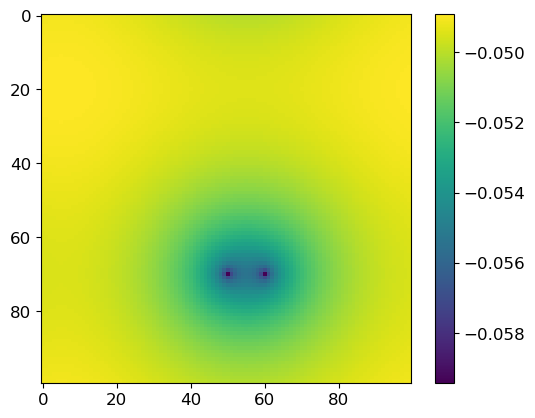

In [290]:
N = 2
Nx = 10**2
Ny = 10**2
Lx = 10
Ly = 10
E = 1
phi = 1
dt = 1
n0 = 1
pos = np.zeros((N,2))
pos[0,0] = 7
pos[0,1] = 5
pos[1,0] = 7
pos[1,1] = 6
#pos[1,0] = 3
#pos[1,1] = 7
ntest, weighttest, phi_grid_test, a = getAccel(pos,E,Nx,Ny,Lx,Ly,dt,n0,N)
print(ntest)
print(weighttest)

print(a)
plt.imshow(phi_grid_test)
plt.colorbar()
plt.show()

C:\Users\evanc\AppData\Local\Temp\ipykernel_7892\3776521790.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  phik[i,j] = -rhok[i,j]/(kx[i]**2 + ky[j]**2)


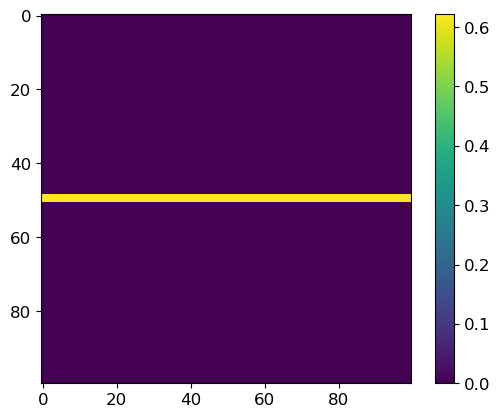

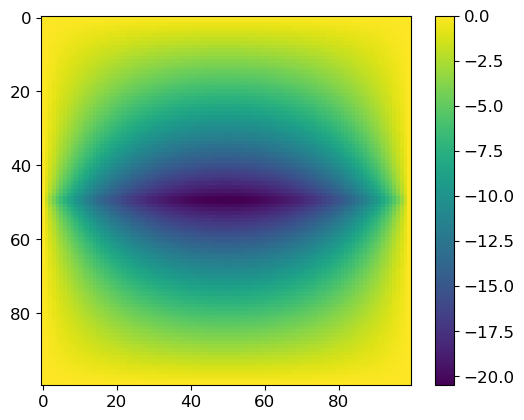

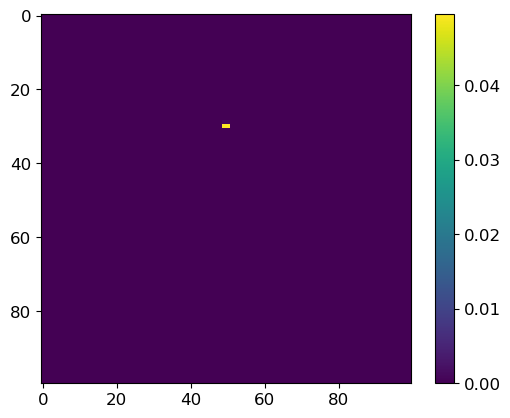

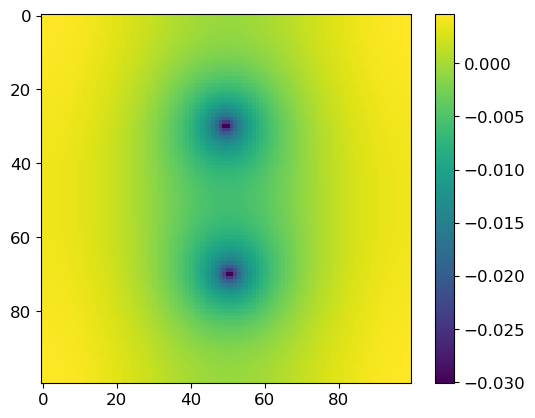

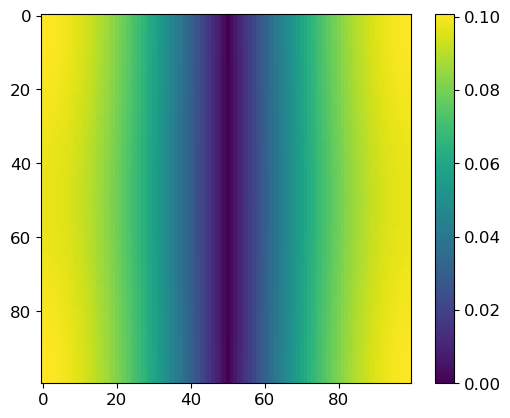

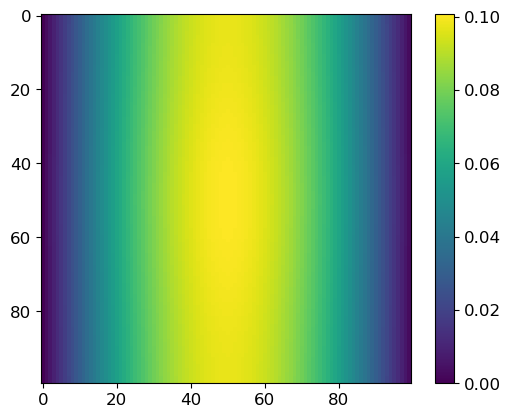

In [313]:
Nx = 10**2
Ny = 10**2
Lx = 10**2
Ly = 10**2
N = 10**2
q = 1
m = 1
eps0 = 1
dx = Lx/Nx
dy = Ly/Ny
rho = np.zeros((Nx,Ny))
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
t = 0.05

def gaussian2d(Nx, Ny, x, y, t):
    # Green's function for the diffusion equation
    g = np.zeros((Nx,Ny))
    for i in range(Nx):
        for j in range(Ny):
            g[i,j] = np.exp(-((x[i]-30)**2 + (y[j]-50)**2)/(2*t)) / (4*np.pi*t)
    return g

def gaussian1d(Nx, x, t):
    # Green's function for the diffusion equation
    g = np.zeros(Nx)
    g = np.exp(-((x-50)**2)/(2*t)) / (np.sqrt(2*np.pi)*t)
    return g

def point_phi(x,y):
    nx = len(x)
    ny = len(y)
    phi = np.zeros((nx,ny))
    for i in range(nx):
        for j in range(ny):
            if x[i] == 0 and y[j] == 0:
                phi[i,j] = 0
            else:
                phi[i,j] = -1/np.sqrt((x[i]-50)**2 + (y[j]-50)**2)
    return phi


rho1d = np.ones((Nx,Ny))
gauss1 = gaussian1d(Nx, x, t)
f = np.zeros((Nx,Ny))
gauss1d_solve = solve(f, rho2d, dx, jacobi, atol=1.E-6, max_steps=10**5)
for i in range(len(rho1d)):
    rho1d[:,i] *= gauss1
f = np.zeros((Nx,Ny))
gauss1d_solve = solve(f, rho1d, dx, jacobi, atol=1.E-6, max_steps=10**5)    
point_phi = point_phi(x,y)
rho2d = gaussian2d(Nx, Ny, x , y, t)

phitest2d, rhok2d=phi_compute(rho2d,eps0,Nx,Ny,dx,dy)
phitest

plt.imshow(rho1d)
plt.colorbar()
plt.show()

plt.imshow(gauss1d_solve)
plt.colorbar()
plt.show()
#plt.imshow(phi_compute(rho1d,eps0,Nx,Ny,dx,dy))
#plt.colorbar()
#plt.show()

plt.imshow(rho2d)
plt.colorbar()
plt.show()

plt.imshow(phitest2d)
plt.colorbar()
plt.show()

plt.imshow(np.abs(rhok2d))
plt.colorbar()
plt.show()

plt.imshow(np.abs(np.fft.fftshift(rhok2d)))
plt.colorbar()
plt.show()

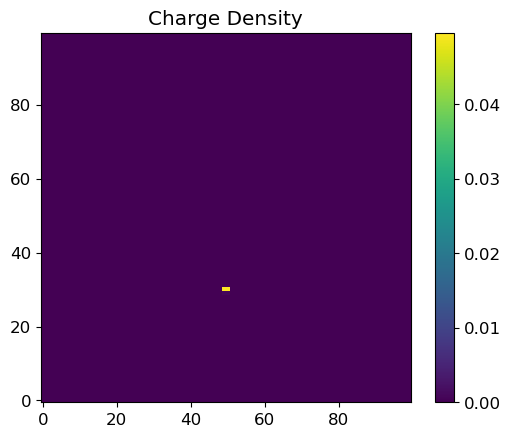

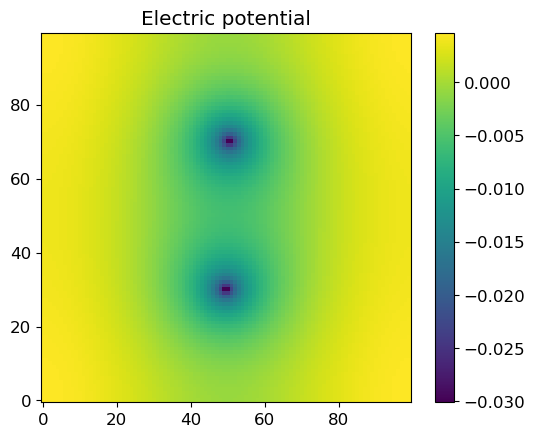

In [320]:
plt.imshow(rho2d, origin = 'lower')
plt.title('Charge Density')
plt.colorbar()
plt.show()

plt.imshow(phitest2d, origin = 'lower')
plt.title('Electric potential')
plt.colorbar()
plt.show()